(example_4)=
# Example 4: Iowa-Gambling Task

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_4_Iowa_Gambling_Task.ipynb)

In [33]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from jax import jit, vjp
from jax.tree_util import Partial
from pyhgf.model import HGF
from pytensor.graph import Apply, Op
from pyhgf.math import binary_surprise, gaussian_surprise

plt.rcParams["figure.constrained_layout.use"] = True

In [21]:
# Set a seed
np.random.seed(420)

Similarly to the [previous example](#example_3) we can also fit the Iowa Gambling Task (IGT) using the HGF. IGT is a developed form of a two-armed bandit task, with the key difference being that 1) the rewards are continuous and 2) the magnitude and the frequency of the rewards differ between the arms, or in this case - decks of cards.

In this task, participants must choose between four decks of cards, each associated with different rewards and punishments. The task is designed to measure decision-making under uncertainty and risk-taking behaviour. The task is typically divided into blocks, and the participant has to learn the reward and punishment probabilities associated with each deck. The task is designed such that two decks are disadvantageous (A and B) and two are advantageous (C and D). The advantageous decks have a higher **total value** compared to the disadvantageous decks.

*insert a picture here illustrating 10 rounds of different decks*

Building on top of Example 3, this notebook will also use missing/unobserved values in the input nodes and custom response functions, with two key additions: the input nodes will now process continuous values and a new parameter will be introduced to model a specific bias in the agent's decision-making, specifically - a preference for decks with high reward frequency.

## Simulating data

### Deck 1

Deck 1, one of the disadvantageous decks, has a baseline reward of 100 but has a high likelihood (50%) of also containing a punishment of -150 to -350. This means that in 50% of the cases, the total reward will be 100 and in the other 50% of cases it will be 100 - (150 to 350).

In [22]:
num_trials = 100

# set default value to 100.0
deck1 = np.ones(num_trials) * 100.0

# 50% chance to add something between -150 and -350
deck1 += np.random.choice(
    [-150, -175, -200, -225, -250, -275, -300, -325, -350], size=num_trials
) * np.random.binomial(1, 0.5, num_trials)

print(f"Total value of Deck 3: {deck1.sum()}")

Total value of Deck 3: -1400.0


### Deck 2

Deck 2, the other disadvantageous deck, has a baseline reward of 100 and a low likelihood (10%) of a high loss of -1250. This means that in 90% of the cases the total reward will be 100 and in 10% of the cases it will be 100 - 1250.

In [26]:
# set default value to 100.0
deck2 = np.ones(num_trials) * 100.0

# 50% chance to add something between -150 and -350
deck2 += -1250.0 * np.random.binomial(1, 0.1, num_trials)

print(f"Total value of Deck 3: {deck2.sum()}")

Total value of Deck 3: -7500.0


### Deck 3

Deck 3 is one of the advantageous decks and has the same structure as Deck 1, but with a baseline reward of 50 and 50% likelihood of a punishment of -25 to -75. Even though its baseline reward is lower than that of Deck 1, it has a higher total value due to the lower punishment magnitude.

In [27]:
# set default value to 100.0
deck3 = np.ones(num_trials) * 50.0

# 50% chance to add something between -150 and -350
deck3 += np.random.choice(
    [-25, -50, -75], size=num_trials
) * np.random.binomial(1, 0.5, num_trials)

print(f"Total value of Deck 3: {deck3.sum()}")

Total value of Deck 3: 2475.0


### Deck 4

Deck 4 is the other advantageous deck, which mirrors the structure of Deck 2, but with a baseline reward of 50 and a 10% likelihood of a punishment of -250. Again, even though its baseline reward is lower than that of Deck 2, it has a higher total value due to the lower punishment magnitude.

In [28]:
# set default value to 100.0
deck4 = np.ones(num_trials) * 50.0

# 50% chance to add something between -150 and -350
deck4 += -250 * np.random.binomial(1, 0.1, num_trials)

print(f"Total value of Deck 3: {deck3.sum()}")

Total value of Deck 3: 2475.0


### Combining the decks

Below, we combine the decks into a list, standardize the values and plot the time series of the rewards for each deck.

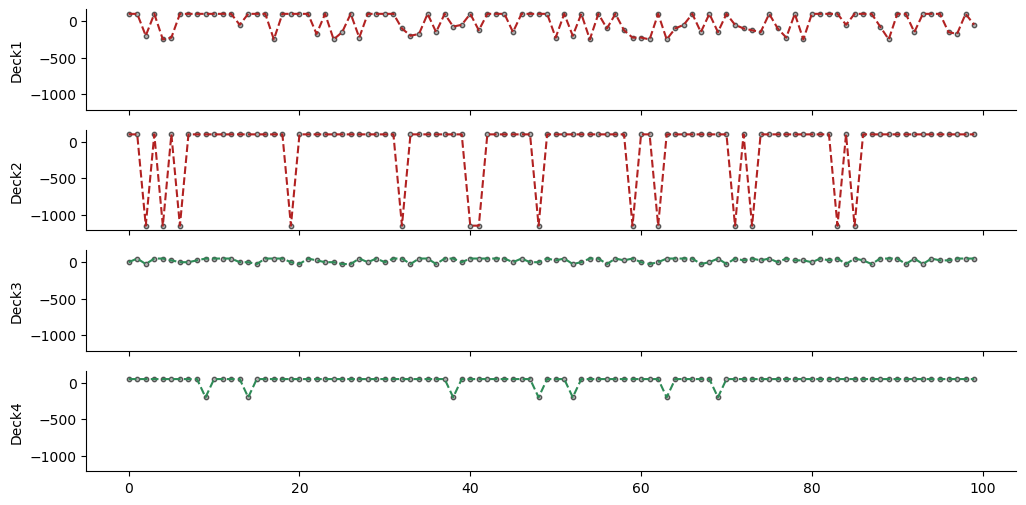

In [34]:
# Visualize the decks
trials = np.arange(num_trials)

_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

for i, u, label, color in zip(
    range(4),
    [deck1, deck2, deck3, deck4],
    ["Deck1", "Deck2", "Deck3", "Deck4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].scatter(
        trials, u, label="outcomes", alpha=0.6, s=10, color="gray", edgecolor="k"
    )
    axs[i].plot(trials, u, "--", color=color)
    axs[i].set_ylabel(label)
sns.despine();

## Model

To model the IGT task, we use a three-level continuous HGF model with the following structure:

1. **input**: the input nodes process the continuous rewards from the decks
2. **x1**: the first node processes the input and computes the expected value of the decks
3. **x2**: the second node is volatility-coupled to the first node and manages the uncertainty in the expected value
3. **x3**: the third node is value-coupled to the second node and affects the mean of the distribution form which x2 samples its value

Importantly, we introduce a new parameter, 'autoconnection_strength' to model the agent's bias towards decks with high reward frequency (insert reference here). This parameter (ranging from 0 to 1) (link) weights the impact of the previous value *k-1* of **x2** on the mean of the distribution from which the current value *k* of **x2** is sampled. 

As **x2** is value-coupled to **x3**, this means that when the *autoconnection_strength* approaches 0, the mean of the distribution of **x2** will be less influenced by the previous value of **x2** and more influenced by the value of **x3**.

(Insert some equations here I guess?)

In practice, this means that whenever there's a highly surprising event (for example a high punishment of -1250 in Deck 2), the agent expectation about the volatility in the environment (Deck 2) will shoot up, but quickly return to the baseline value due to the decreased influence of previous observation of **x2**. This autoregressive effect is used to model the agent's bias towards decks with high reward frequency. We can hypothesise that *autoconnection_strength* will be generally lower in networks that are fitted to Decks 2 and 4, which have a high reward frequency.

Let's see this in practice.

### Single HGF: Volatility with Autoconnection Strength

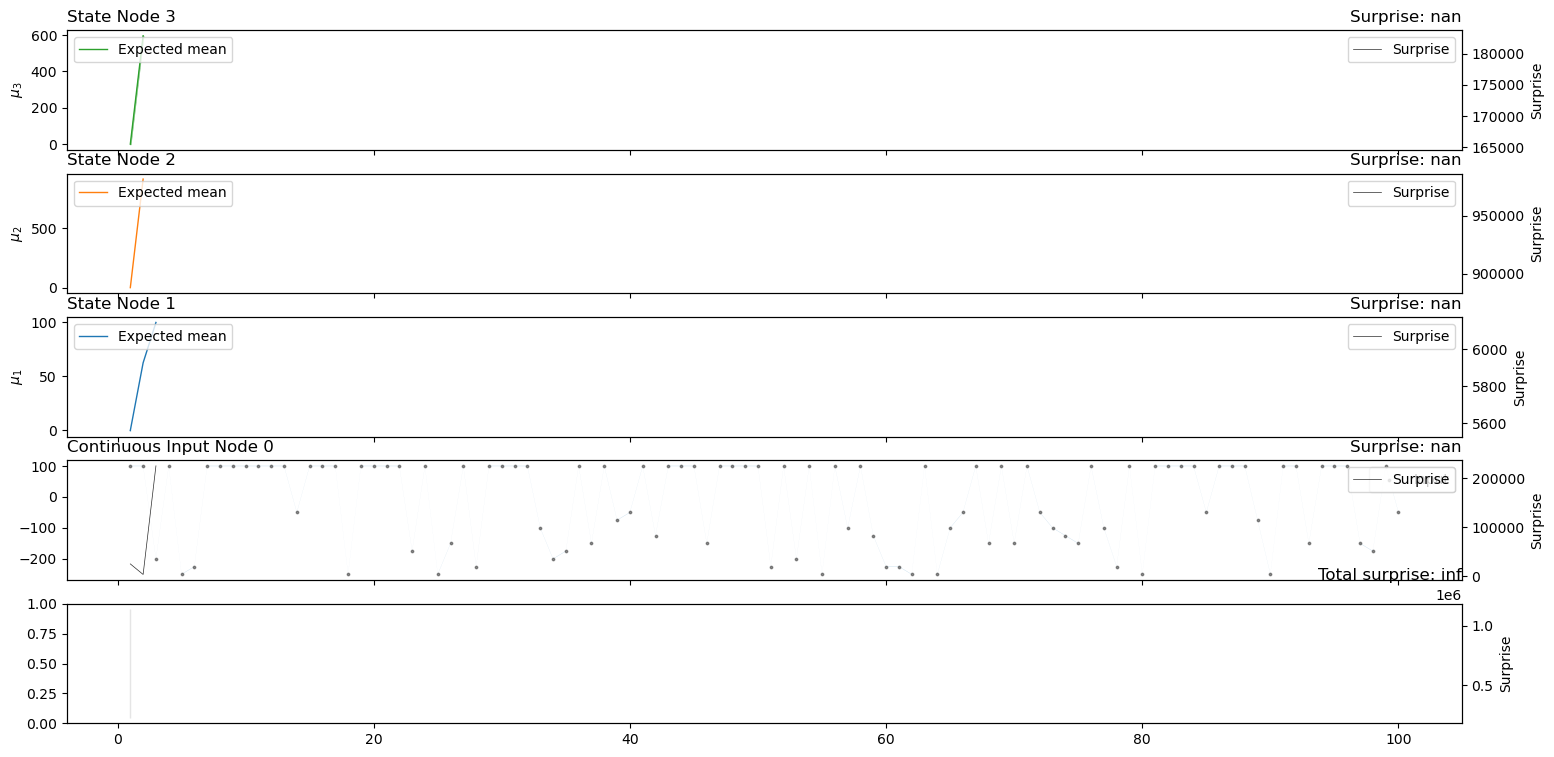

In [36]:
# First we create a single HGF network to model Deck A (50% chance of -150 to -350), with autoconnection strength set to 0.4

two_levels_continuous_hgf = (
    HGF(model_type=None)
    .add_nodes(kind="continuous-input", n_nodes=1, input_precision=5.0)
    .add_nodes(
        kind="continuous-state",
        value_children=0,
        tonic_volatility=-2.0,
        precision=5.0,
        mean=0.0,
    )
    .add_nodes(
        volatility_children=1,
        tonic_volatility=-2.0,
        precision=5.0,
        autoconnection_strength=0.4,
    )
    .add_nodes(value_children=2, precision=1.0)
)

# Provide new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(
    input_data=np.asarray(decks_std[0])
)

# Plot the node trajectories
two_levels_continuous_hgf.plot_trajectories();

As can be seen in the plot above, the agent's expectation about the volatility in the Deck A more or less smoothly increases as the task progresses, as the agent is constantly (50% of the time) met with negative rewards. Now let's see with Deck B.

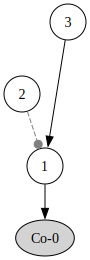

In [11]:
# First we create a single HGF network to model Deck B (10% chance of -1250), with autoconnection strength set to 0.4

two_levels_continuous_hgf = (
    HGF(model_type=None)
    .add_nodes(kind="continuous-input", n_nodes=1, input_precision=5.0)
    .add_nodes(
        kind="continuous-state",
        value_children=0,
        tonic_volatility=-2.0,
        precision=5.0,
        mean=0.0,
        autoconnection_strength=0.1,
    )
    .add_nodes(volatility_children=1, tonic_volatility=-2.0, precision=5.0)
    .add_nodes(value_children=1, tonic_volatility=-2.0, precision=5.0, mean=0.3)
    #    .add_nodes(value_children=2, precision = 5.0)
)

# Provide new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(
    input_data=np.asarray(decks_std[1])
)

# plot network
two_levels_continuous_hgf.plot_network()

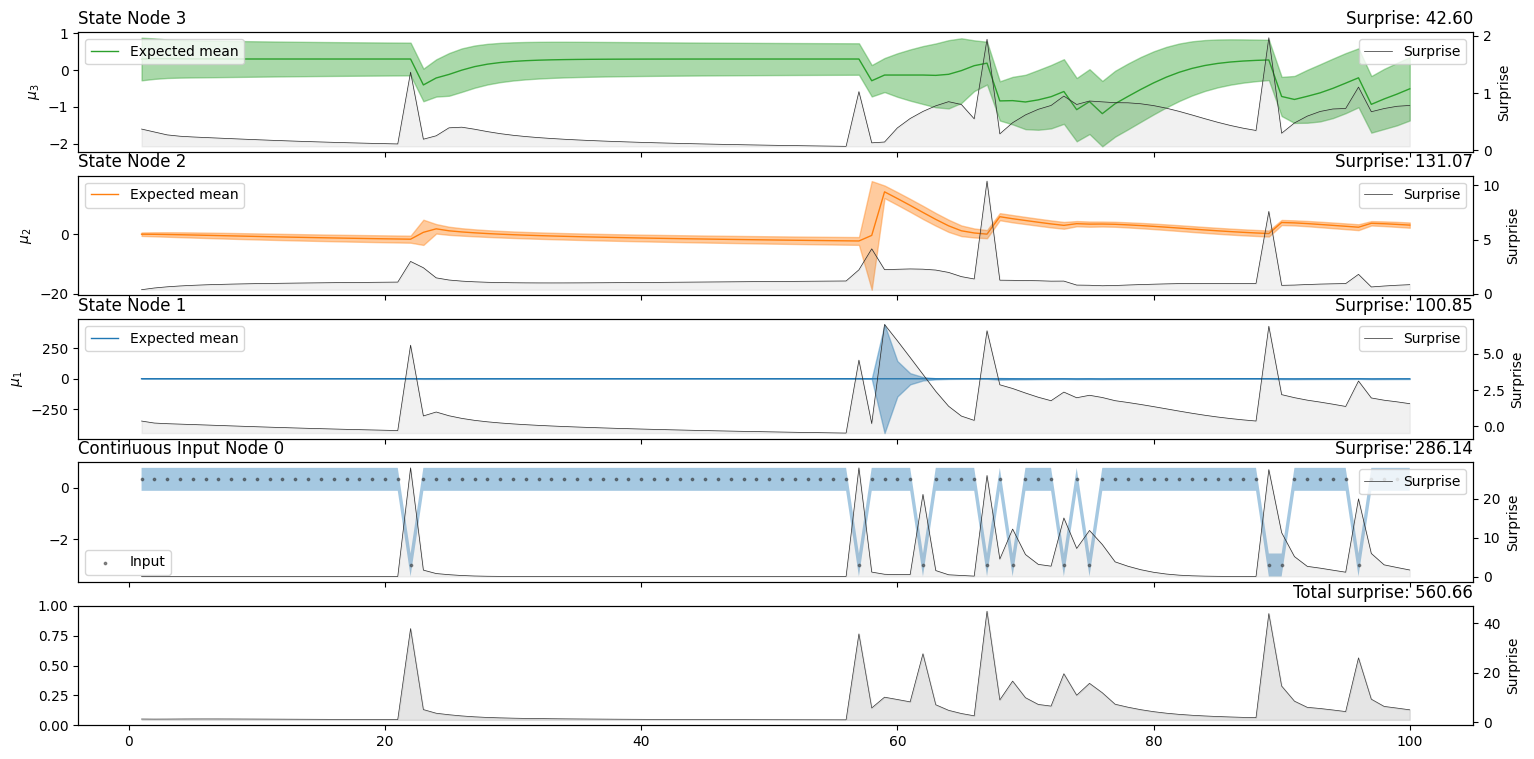

In [12]:
# Plot the node trajectories
two_levels_continuous_hgf.plot_trajectories();

In [ ]:
df = two_levels_continuous_hgf.to_pandas()
df.head(50)

As we can see, the agent's expectation about the value in Deck B returns to the basline value much quicker than in Deck A, as the agent is only met with negative rewards 10% of the time. This is due to the autoregressive effect of the *autoconnection_strength* parameter, which decreases the influence of the previous value of **x2** on the mean of the distribution from which the current value of **x2** is sampled.

## Single HGF: Value with Autoconnection Strength

Let's try another structure, where the mid level node is value-coupled to **x1**.

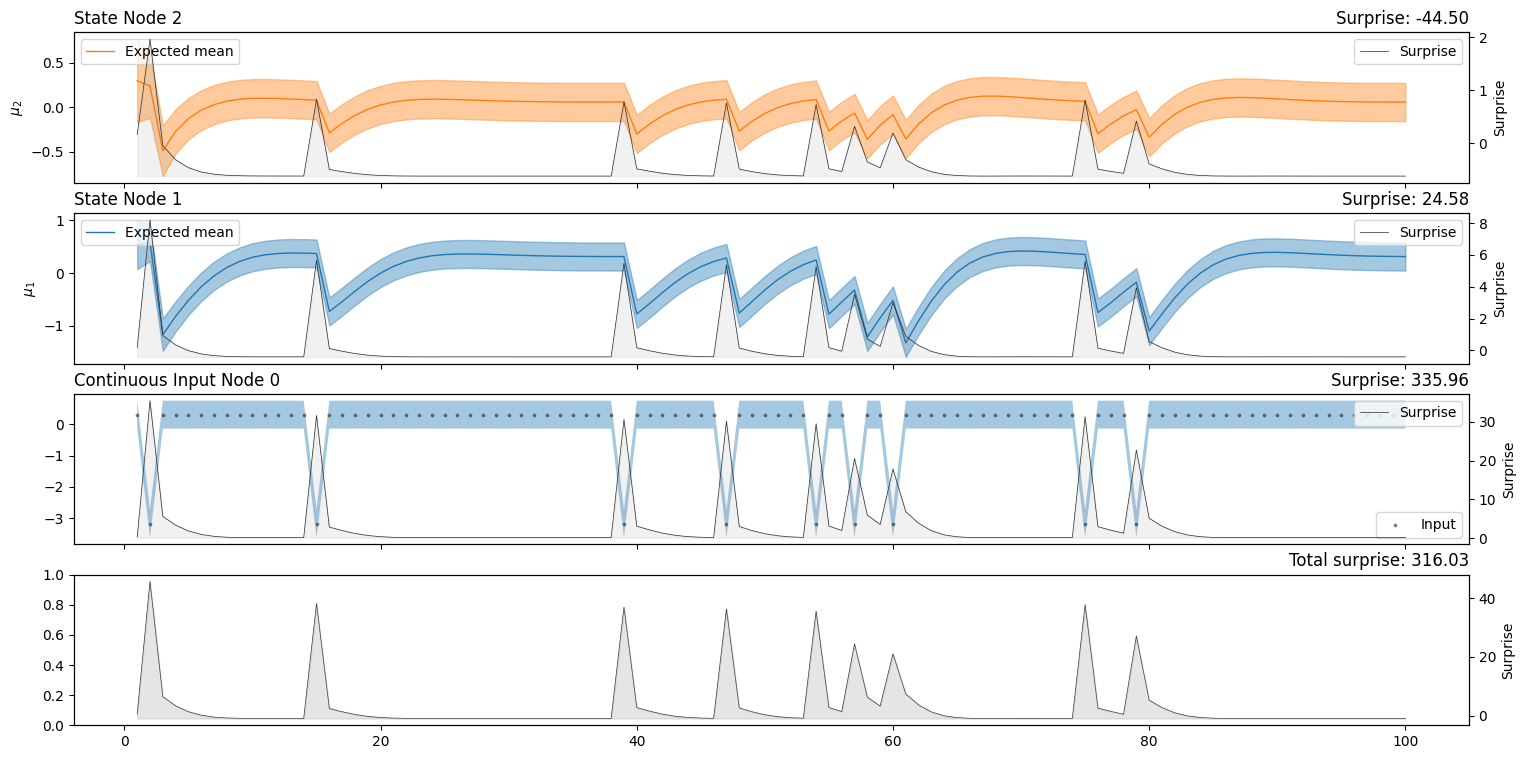

In [11]:
# First we create a single HGF network to model Deck B (10% chance of -1250), with autoconnection strength set to 0.4

two_levels_continuous_hgf = (
    HGF(model_type=None)
    .add_nodes(kind="continuous-input", n_nodes=1, input_precision=5.0)
    .add_nodes(
        kind="continuous-state",
        value_children=0,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=0.8,
    )
    .add_nodes(value_children=1, precision=5.0, mean=0.3)
)

# Provide new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(
    input_data=np.asarray(decks[1])
)

# Plot the node trajectories
two_levels_continuous_hgf.plot_trajectories();

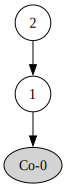

In [16]:
two_levels_continuous_hgf.plot_network()

In [ ]:
df = two_levels_continuous_hgf.to_pandas()
df.head(50)

# Multiple HGFs

Now we build a model with 4 HGFs, one for each deck. Every HGF will have the same structure as above - the **continuous input** nodes has a value parent - the **x1** node, and it in turn has its own value parent - **x2** node. The **x1** nodes will have the *autoconnection_strength* parameter, which will model the agent's bias towards decks with high reward frequency - for Decks 2 and 4, this parameter will be lower than for Decks 1 and 3. Effectively, this means that for Decks 2 and 4, the agent will be **less** influenced by the previous value of **x1** and rely more on its parents **x2** contribution. 

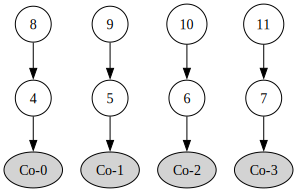

In [7]:
autoconnection_strengths_1_3 = 0.8
autoconnection_strengths_2_4 = 0.3

two_levels_continuous_hgf = (
    HGF(model_type=None)
    # First four input nodes
    .add_nodes(kind="continuous-input", n_nodes=4, input_precision=5.0)
    .add_nodes(
        kind="continuous-state",
        value_children=0,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=autoconnection_strengths_1_3,
    )
    .add_nodes(
        kind="continuous-state",
        value_children=1,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=autoconnection_strengths_2_4,
    )
    .add_nodes(
        kind="continuous-state",
        value_children=2,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=autoconnection_strengths_1_3,
    )
    .add_nodes(
        kind="continuous-state",
        value_children=3,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=autoconnection_strengths_2_4,
    )
    .add_nodes(value_children=4, precision=1.0)
    .add_nodes(value_children=5, precision=1.0)
    .add_nodes(value_children=6, precision=1.0)
    .add_nodes(value_children=7, precision=1.0)
)

two_levels_continuous_hgf.plot_network()

In [8]:
# Make our input vector
u = np.array([decks[0], decks[1], decks[2], decks[3]])

In [9]:
# Lets feed our hgf the data
two_levels_continuous_hgf.input_data(input_data=u.T);

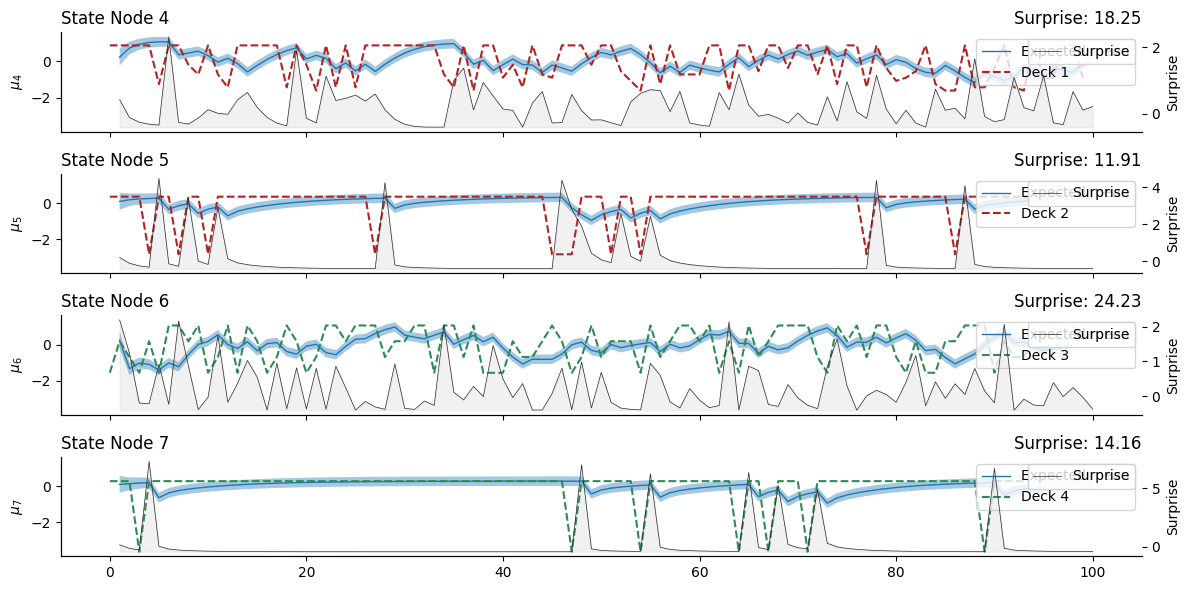

In [10]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_levels_continuous_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_levels_continuous_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_levels_continuous_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_levels_continuous_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [decks[0], decks[1], decks[2], decks[3]],
    ["Deck 1", "Deck 2", "Deck 3", "Deck 4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend(loc="upper right")
plt.tight_layout()
sns.despine();

Simulate responses from the participant

In [12]:
def softmax(means, variances, beta_1, beta_2):
    """
    Compute the softmax of vector x using an inverse temperature parameter beta.

    Parameters:
    - x: Input vector
    - beta: Inverse temperature parameter

    Returns:
    - Softmax of the input vector x
    """
    x = np.array(means)
    y = np.array(variances)
    exp_x = np.exp(beta_1 * x + beta_2 * y)
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

In [13]:
# Simulating choices for the participant
beta_1 = 1
beta_2 = 1

mean_1 = two_levels_continuous_hgf.node_trajectories[4]["expected_mean"]
mean_2 = two_levels_continuous_hgf.node_trajectories[5]["expected_mean"]
mean_3 = two_levels_continuous_hgf.node_trajectories[6]["expected_mean"]
mean_4 = two_levels_continuous_hgf.node_trajectories[7]["expected_mean"]

var_1 = 1 / two_levels_continuous_hgf.node_trajectories[4]["expected_precision"]
var_2 = 1 / two_levels_continuous_hgf.node_trajectories[5]["expected_precision"]
var_3 = 1 / two_levels_continuous_hgf.node_trajectories[6]["expected_precision"]
var_4 = 1 / two_levels_continuous_hgf.node_trajectories[7]["expected_precision"]

choices = []

for i in range(100):
    means = [mean_1[i], mean_2[i], mean_3[i], mean_4[i]]
    variances = [var_1[i], var_2[i], var_3[i], var_4[i]]
    x = softmax(means, variances, 1.0, 1.0)
    choice = np.where(x == max(x))[0][0]  # this should be a categorical_logit?
    choice = int(choice)
    choices.append(choice)

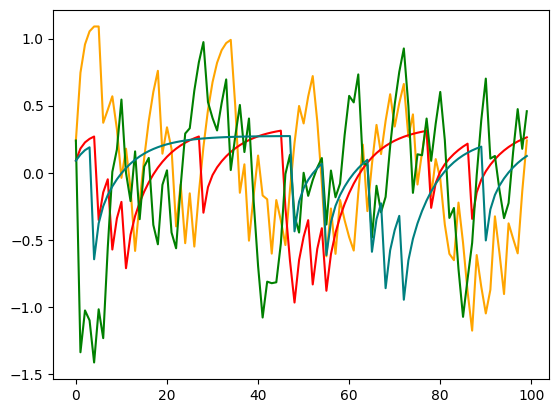

In [14]:
plt.plot(range(len(mean_1)), mean_1, color="orange")
plt.plot(range(len(mean_2)), mean_2, color="red")
plt.plot(range(len(mean_3)), mean_3, color="green")
plt.plot(range(len(mean_4)), mean_4, color="teal")

In [15]:
# a new matrix of observations
missing_inputs_u = u.astype(float)

# Create an observed array based on the choices made
observed = np.zeros(u.shape)

for i, c in enumerate(choices):
    observed[c, i] = 1

Make a new network

In [55]:
# Legacy HGF

# two_levels_continuous_hgf = (
#     HGF(model_type=None)
#     # First four input nodes
#     .add_nodes(kind="continuous-input", n_nodes=4, input_precision = 1.0)
#     .add_nodes(kind="continuous-state", value_children=0, tonic_volatility=-4, precision = 5, mean = 1.0)
#     .add_nodes(kind="continuous-state", value_children=1, tonic_volatility=-4, precision = 5, mean = 1.0)
#     .add_nodes(kind="continuous-state", value_children=2, tonic_volatility=-4, precision = 5, mean = 1.0)
#     .add_nodes(kind="continuous-state", value_children=3, tonic_volatility=-4, precision = 5, mean = 1.0)
#     .add_nodes(volatility_children=4, tonic_volatility=-3, precision = 1.0)
#     .add_nodes(volatility_children=5, tonic_volatility=-3, precision = 1.0)
#     .add_nodes(volatility_children=6, tonic_volatility=-3, precision = 1.0)
#     .add_nodes(volatility_children=7, tonic_volatility=-3, precision = 1.0)
#     .add_nodes(value_children=8, autoconnection_strength=1, precision = 2)
#     .add_nodes(value_children=9, autoconnection_strength=1, precision = 2)
#     .add_nodes(value_children=10, autoconnection_strength=1, precision = 2)
#     .add_nodes(value_children=11, autoconnection_strength=1, precision = 2)
# )

# two_levels_continuous_hgf.plot_network()

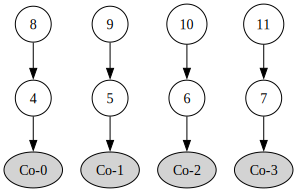

In [61]:
two_levels_continuous_hgf = (
    HGF(model_type=None)
    # First four input nodes
    .add_nodes(kind="continuous-input", n_nodes=4, input_precision=5.0)
    .add_nodes(
        kind="continuous-state",
        value_children=0,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=0.8,
    )
    .add_nodes(
        kind="continuous-state",
        value_children=1,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=0.3,
    )
    .add_nodes(
        kind="continuous-state",
        value_children=2,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=0.8,
    )
    .add_nodes(
        kind="continuous-state",
        value_children=3,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=0.3,
    )
    .add_nodes(value_children=4, precision=1.0)
    .add_nodes(value_children=5, precision=1.0)
    .add_nodes(value_children=6, precision=1.0)
    .add_nodes(value_children=7, precision=1.0)
)

two_levels_continuous_hgf.plot_network()

In [62]:
# note that we are providing the mask as parameter of the input function
two_levels_continuous_hgf.input_data(
    input_data=missing_inputs_u.T,
    observed=observed.T,
);

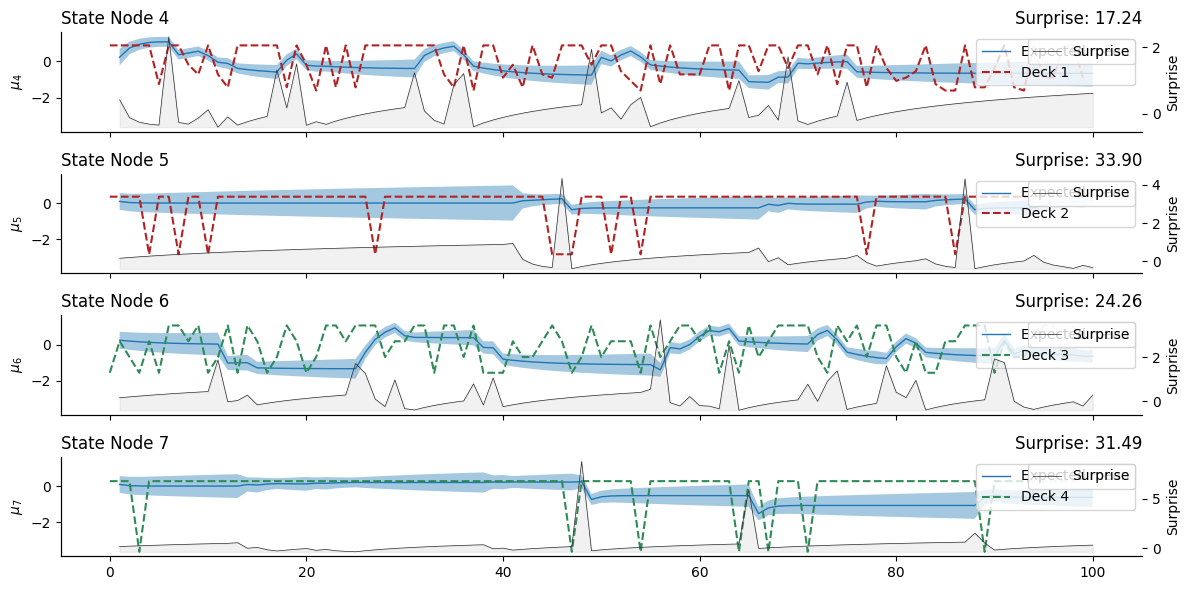

In [63]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_levels_continuous_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_levels_continuous_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_levels_continuous_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_levels_continuous_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [decks[0], decks[1], decks[2], decks[3]],
    ["Deck 1", "Deck 2", "Deck 3", "Deck 4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend(loc="upper right")

plt.tight_layout()
sns.despine();

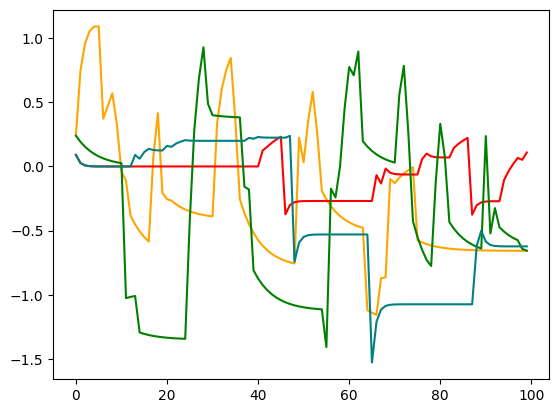

In [64]:
v_1 = two_levels_continuous_hgf.node_trajectories[4]["expected_mean"]
v_2 = two_levels_continuous_hgf.node_trajectories[5]["expected_mean"]
v_3 = two_levels_continuous_hgf.node_trajectories[6]["expected_mean"]
v_4 = two_levels_continuous_hgf.node_trajectories[7]["expected_mean"]

plt.plot(range(len(v_1)), v_1, color="orange")
plt.plot(range(len(v_2)), v_2, color="red")
plt.plot(range(len(v_3)), v_3, color="green")
plt.plot(range(len(v_4)), v_4, color="teal")

In [88]:
from pyhgf.utils import beliefs_propagation

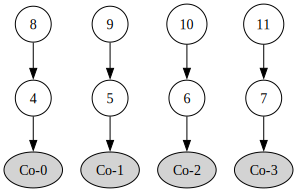

In [89]:
two_levels_continuous_hgf = (
    HGF(model_type=None)
    # First four input nodes
    .add_nodes(kind="continuous-input", n_nodes=4, input_precision=5.0)
    .add_nodes(
        kind="continuous-state",
        value_children=0,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=0.8,
    )
    .add_nodes(
        kind="continuous-state",
        value_children=1,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=0.3,
    )
    .add_nodes(
        kind="continuous-state",
        value_children=2,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=0.8,
    )
    .add_nodes(
        kind="continuous-state",
        value_children=3,
        tonic_volatility=-4.0,
        precision=5.0,
        mean=0.3,
        autoconnection_strength=0.3,
    )
    .add_nodes(value_children=4, precision=1.0)
    .add_nodes(value_children=5, precision=1.0)
    .add_nodes(value_children=6, precision=1.0)
    .add_nodes(value_children=7, precision=1.0)
)

two_levels_continuous_hgf.plot_network()

In [90]:
# get the network variables from the HGF class
attributes, structure, update_sequence = two_levels_continuous_hgf.get_network()

In [91]:
input_data = u.astype(float).T
responses = []

# for each observation
for i in range(input_data.shape[0]):

    # the observation mask - default to 1
    observed = np.ones(4)

    # the time elapsed between two trials - defaults to 1
    time_steps = np.ones(1)

    # the expectations about the outcomes
    mean_1 = attributes[4]["expected_mean"]
    mean_2 = attributes[5]["expected_mean"]
    mean_3 = attributes[6]["expected_mean"]
    mean_4 = attributes[7]["expected_mean"]

    var_1 = 1 / attributes[4]["expected_precision"]
    var_2 = 1 / attributes[5]["expected_precision"]
    var_3 = 1 / attributes[6]["expected_precision"]
    var_4 = 1 / attributes[7]["expected_precision"]

    means = [mean_1, mean_2, mean_3, mean_4]
    variances = [var_1, var_2, var_3, var_4]

    # compute the softmax
    x = softmax(means, variances, 1.0, 1.0)

    response = np.where(x == max(x))[0][0]
    response = int(response)

    responses.append(response)

    # hide the observations that were not selected
    observed[response] = 1

    # update the probabilistic network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        input_data=(input_data[i], time_steps, observed),
        update_sequence=update_sequence,
        structure=structure,
    )
responses = jnp.asarray(responses)  # vector of responses

In [92]:
# Remake the observed variable
observed = np.zeros(u.shape)

for i, c in enumerate(choices):
    observed[c, i] = 1

In [102]:
# Build the function
autoregression_strength_1 = 0.8
autoregression_strength_2 = 0.3

# vectorize the shit out of the below


def IGT_logp(
    autoregression_strength_1,
    autoregression_strength_2,
    hgf,
    input_data,
    responses,
    observed,
):

    two_levels_continuous_hgf.attributes[4][
        "autoconnection_strength"
    ] = autoregression_strength_1
    two_levels_continuous_hgf.attributes[5][
        "autoconnection_strength"
    ] = autoregression_strength_2
    two_levels_continuous_hgf.attributes[6][
        "autoconnection_strength"
    ] = autoregression_strength_1
    two_levels_continuous_hgf.attributes[7][
        "autoconnection_strength"
    ] = autoregression_strength_2

    # run the model forward
    hgf.input_data(input_data=input_data.T, observed=observed.T)

    # the expectations about the outcomes
    d_1_m = two_levels_continuous_hgf.node_trajectories[4]["expected_mean"]
    d_2_m = two_levels_continuous_hgf.node_trajectories[5]["expected_mean"]
    d_3_m = two_levels_continuous_hgf.node_trajectories[6]["expected_mean"]
    d_4_m = two_levels_continuous_hgf.node_trajectories[7]["expected_mean"]

    # the expectations about the outcomes
    d_1_p = 1 / two_levels_continuous_hgf.node_trajectories[4]["expected_precision"]
    d_2_p = 1 / two_levels_continuous_hgf.node_trajectories[5]["expected_precision"]
    d_3_p = 1 / two_levels_continuous_hgf.node_trajectories[6]["expected_precision"]
    d_4_p = 1 / two_levels_continuous_hgf.node_trajectories[7]["expected_precision"]

    # Make a means vector
    expected_means = np.array([d_1_m, d_2_m, d_3_m, d_4_m])

    # Make a precisions vector
    expected_variances = np.array([d_1_p, d_2_p, d_3_p, d_4_p])

    # Compute the softmax
    x = softmax(expected_means, expected_variances, 1.0, 1.0)

    # Compute the surprise for each trial using the binary surprise function

    # First we need to turn the responses into a 4x100 matrix with 0s and 1s. The value of the response vector at index i governs which column in the matrix will be 1 at index i.
    # This is because the response vector is a vector of integers from 0 to 3, and we want to turn it into a one-hot encoded matrix.

    # Initialize an empty matrix
    empty_matrix = np.zeros(u.shape)

    # Loop through the responses vector
    for i, c in enumerate(responses):
        # Set the value at the index of the response to 1
        empty_matrix[c, i] = 1

    # Now we can compute the surprise for each deck for each trial
    surprise = jnp.sum(binary_surprise(x=empty_matrix[0], expected_mean=x[0]))
    surprise += jnp.sum(binary_surprise(x=empty_matrix[1], expected_mean=x[1]))
    surprise += jnp.sum(binary_surprise(x=empty_matrix[2], expected_mean=x[2]))
    surprise += jnp.sum(binary_surprise(x=empty_matrix[3], expected_mean=x[3]))

    # # Initialize empty lists for 'expected_means', 'expected_precisions', and 'x'
    # expected_means = [] # expected means for each trial
    # expected_precisions = [] # expected precisions for each trial
    # actual = [] # actual outcome of the trial, using our original deck1, deck2, deck3 and deck4 vectors

    # Loop through the responses vector
    # for step, response in enumerate(responses):
    #     # Depending on the response value, select the corresponding vectors
    #     if response == 0:
    #         expected_means.append(d_1_m[step])
    #         expected_precisions.append(d_1_p[step])
    #         actual.append(decks[0][step])
    #     elif response == 1:
    #         expected_means.append(d_2_m[step])
    #         expected_precisions.append(d_2_p[step])
    #         actual.append(decks[1][step])
    #     elif response == 2:
    #         expected_means.append(d_3_m[step])
    #         expected_precisions.append(d_3_p[step])
    #         actual.append(decks[2][step])
    #     elif response == 3:
    #         expected_means.append(d_4_m[step])
    #         expected_precisions.append(d_4_p[step])
    #         actual.append(decks[3][step])

    # # Convert lists to arrays
    # expected_means = np.array(expected_means)
    # expected_precisions = np.array(expected_precisions)
    # actual = np.array(actual)

    # # calculate surprise
    # surprise = jnp.sum(gaussian_surprise(x = actual, expected_mean = expected_means, expected_precision = expected_precisions))

    # # just to binary surprise for each unique observation

    # surprise += jnp.sum(two_levels_continuous_hgf.node_trajectories[0]["surprise"])
    # surprise += jnp.sum(two_levels_continuous_hgf.node_trajectories[1]["surprise"])
    # surprise += jnp.sum(two_levels_continuous_hgf.node_trajectories[2]["surprise"])
    # surprise += jnp.sum(two_levels_continuous_hgf.node_trajectories[3]["surprise"])

    surprise = jnp.where(jnp.isnan(surprise), jnp.inf, surprise)
    return -surprise

In [103]:
# Run the function
surprise = IGT_logp(
    autoregression_strength_1,
    autoregression_strength_2,
    two_levels_continuous_hgf,
    u,
    responses,
    observed,
)
print(surprise)

-209.94894


In [112]:
logp_fn = Partial(
    IGT_logp,
    hgf=two_levels_continuous_hgf,
    input_data=input_data,
    responses=responses,
    observed=observed.T,
)

In [113]:
jitted_custom_op_jax = jit(logp_fn)

def vjp_custom_op_jax(x, gz):
    _, vjp_fn = vjp(logp_fn, x)
    return vjp_fn(gz)[0]

jitted_vjp_custom_op_jax = jit(vjp_custom_op_jax)

In [110]:
# The CustomOp needs `make_node`, `perform` and `grad`.
class CustomOp(Op):
    def make_node(self, x):
        # Create a PyTensor node specifying the number and type of inputs and outputs

        # We convert the input into a PyTensor tensor variable
        inputs = [pt.as_tensor_variable(x)]
        # Output has the same type and shape as `x`
        outputs = [inputs[0].type()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        # Evaluate the Op result for a specific numerical input

        # The inputs are always wrapped in a list
        (x,) = inputs
        result = jitted_custom_op_jax(x)
        # The results should be assigned in place to the nested list
        # of outputs provided by PyTensor. If you have multiple
        # outputs and results, you should assign each at outputs[i][0]
        outputs[0][0] = np.asarray(result, dtype="float64")

    def grad(self, inputs, output_gradients):
        # Create a PyTensor expression of the gradient
        (x,) = inputs
        (gz,) = output_gradients
        # We reference the VJP Op created below, which encapsulates
        # the gradient operation
        return [vjp_custom_op(x, gz)]


class VJPCustomOp(Op):
    def make_node(self, x, gz):
        # Make sure the two inputs are tensor variables
        inputs = [pt.as_tensor_variable(x), pt.as_tensor_variable(gz)]
        # Output has the shape type and shape as the first input
        outputs = [inputs[0].type()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (x, gz) = inputs
        result = jitted_vjp_custom_op_jax(x, gz)
        outputs[0][0] = np.asarray(result, dtype="float64")


# Instantiate the Ops
custom_op = CustomOp()
vjp_custom_op = VJPCustomOp()

In [111]:
with pm.Model() as model:
    omega = pm.Normal("omega", -4.0, 5)
    pm.Potential("hgf", custom_op(omega))
    idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


TypeError: IGT_logp() missing 1 required positional argument: 'autoregression_strength_2'
Apply node that caused the error: CustomOp(omega)
Toposort index: 1
Inputs types: [TensorType(float64, shape=())]
Inputs shapes: [()]
Inputs strides: [()]
Inputs values: [array(-3.53877925)]
Outputs clients: [['output']]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/baskakovs/Documents/GitHub/hgf_24/hgf-24/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
    result = runner(coro)
  File "/Users/baskakovs/Documents/GitHub/hgf_24/hgf-24/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/baskakovs/Documents/GitHub/hgf_24/hgf-24/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/baskakovs/Documents/GitHub/hgf_24/hgf-24/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/baskakovs/Documents/GitHub/hgf_24/hgf-24/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/rm/_7rkq2vn3718t6vzkzstldjw0000gn/T/ipykernel_91695/2889059763.py", line 3, in <module>
    pm.Potential("hgf", custom_op(omega))
  File "/Users/baskakovs/Documents/GitHub/hgf_24/hgf-24/lib/python3.9/site-packages/pytensor/graph/op.py", line 295, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/var/folders/rm/_7rkq2vn3718t6vzkzstldjw0000gn/T/ipykernel_91695/957391101.py", line 9, in make_node
    outputs = [inputs[0].type()]

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.